In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021).

$\psi(P_0) = \mathbb{E}[Y|X=x]$  is our target estimand - it is the conditional outcome mean.

i.e. $$\psi(P_0) = \int y \frac{f_{y,x}(y,x)}{f_x(x)} dy $$


If we assume the distribution from which the densities $f$ derive has been perturbed by a point mass at $(\tilde x, \tilde y)$ then:

i.e. $$\psi(P_t) = \int y \frac{f_{y,x,t}(y,x)}{f_{x,t}(x)} dy $$

where $f_{y,x,t}(y,x)$ and $f_{x,t}(x)$ are the joint and marginal densities of $(Y,X)$ and $(X)$ respectively, under the 'parametric submodel' $$P_t = t\delta_x(\tilde x) + (1-t)P_o$$ and where $\delta_x(\tilde x)$ denotes the Dirac delta function s.t. it gives the density of a point mass at $\tilde x$, is zero everywhere else, and integrates to 1.

For our densities we therefore have that:

$$f_{y,x,t}(x,y) =  t \delta_{x,y}(\tilde x, \tilde y) +  (1-t)f_{x,y}(x,y)$$

and

$$f_{x,t}(x) =  t \delta_{x}(\tilde x) +  (1-t)f_{x}(x)$$

For some single observation $\tilde o$, the influence function can be written as:

$$\phi(\tilde o, P) = \left. \frac{d\psi(P_t)}{dt} \right \vert_{t=0} = \int y \left . \frac{d}{dt} \right \vert_{t=0}\frac{f_{x,y,t}(x,y)}{f_{x,t}(x)}dy$$

Following the quotient rule:
$$\phi(\tilde o, P) = \int\left .\frac{y}{f(x)} \frac{df_{x,y,t}(x,y)}{dt} \right \vert_{t=0} dy  - \int\left .\frac{ydf_{x,t}(x)}{dt} \frac{f_{x,y,t}(x,y)}{f(x)^2} \right \vert_{t=0} dy$$

Now $$\left. \frac{df_{y,x,t}(x,y)}{dt}\right \vert_{t=0} =  \delta_{x,y}(\tilde x, \tilde y) -f_{x,y}(x,y)$$

and 
$$\left. \frac{df_{x,t}(x)}{dt} \right \vert_{t=0} =  \delta_{x}(\tilde x) -f_{x}(x)$$

Therefore, with some manipulation and remembering that $\delta_{x,y}(\tilde x, \tilde y) = \delta_{x}(\tilde x) \delta_{y}(\tilde y) $

$$ \phi(\tilde o, P) = \frac{\delta_{x}(\tilde x) }{f(\tilde x)} \left( \tilde y - \mathbb{E}[Y|X=\tilde x]\right )$$

This is fine if $X$ is discrete, since in this case $\delta_{x}(\tilde x)$ is the indicator function $\mathbb{1}_x(\tilde x)$ which equals 1 when $x=\tilde x$.

Finally we want to update our initial estimate as:

$$ \psi(P) \approx \psi(P_n) + \frac{1}{N}\sum_{i=0}^N\phi(\tilde o_i, P_n)$$

which follows the Von Mises process for approximating a functional at an unknown distribution as a sum of terms involving the functional at the current distribution plus some derivatives (in our case, pathwise derivative) and higher order terms. 

In [2]:
# define a function that returns p(X=x) given the PMF p(X) and space of possible X
def pmf(x, cats, p_cats):
    ''' takes in set of possible outcomes 'cats' and corresponding probabilitys p_cats
    output is probability of specified event 'x' '''
    ind = np.where((cats==x).all(axis=1))[0][0]
    return p_cats[ind]


def data_gen(N, beta):
    X0 = np.array([1.0]).repeat(N).reshape(-1, 1)
    X1 = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X2 = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X3 = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X4 = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X = np.concatenate([X0, X1, X2, X3, X4, X2*X3], 1)
    u =  0.5*np.random.randn(N)
    y = np.log((np.dot(X, beta)) + u**2)
    
    return X[:,1:-1], X, y, u  # first output is the variables without the constant and interaction


In [8]:
num_loops = 50
k = 6
N = 5000
# set our query value of X=x:
cond_X_GT = np.array([1., 1., 0., 1., 0., 0.])  # note the last var has to be X2*X3

cond_X_est = cond_X_GT[1:-1]  # excludes offset and interaction. 
beta = np.array([3.3, 0.6, 0.5, 0.9, 0.6, 1.0])  # set beta/coefficients to some values
# we run multiple loops over a k-fold procedure to get an understanding of the variance
# in bias reduction.

reductions = []
for i in range(num_loops):
    print('Running loop:', i+1)

    X, X_all, y, u = data_gen(N=N, beta=beta)  # generate the data
    # simulated data gen process (without noise) for purposes of finding E(Y|X=x)
    Psi_GT = np.log(np.dot(cond_X_GT, beta)) 
    
    kf = KFold(n_splits=k, shuffle=True)
    kf.get_n_splits(X)
    psis = []
    phis = []
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        reg = RandomForestRegressor().fit(X_train, y_train)
        psi = reg.predict((cond_X_est).reshape(1, -1))
        psis.append(psi)

        # return the set of possible outcomes, and their counts for X_ds1
        cats_train, counts_train = np.unique(X_train, axis=0,return_counts=True)
        p_cats_train = counts_train / len(X_train)  # this returns the normalized probabilities for each possible outcome

        all_phi = []
        for i in range(len(X_test)):
            y_tilde = y_test[i]
            x_tilde = X_test[i]
            EY_tildeX = reg.predict(x_tilde.reshape(1, -1))
            y_Ey = y_tilde - EY_tildeX
            if (x_tilde == cond_X_est).all():
                delta_over_fx = 1 / pmf(x_tilde, cats_train, p_cats_train)
            else:
                delta_over_fx = 0
            all_phi.append(delta_over_fx * y_Ey)

        phis = np.asarray(all_phi)
    phi = phis.mean()
    psi = np.asarray(psis).mean()    
    psi_est_updated = psi + phi
    red = (np.abs(psi-Psi_GT) / Psi_GT * 100) - (np.abs(psi_est_updated-Psi_GT) / Psi_GT * 100)
    print('reduction:', red)
    reductions.append(red)

Running loop: 1
reduction: -0.813079355275033
Running loop: 2
reduction: 1.0493195548245322
Running loop: 3
reduction: -0.9559021934353069
Running loop: 4
reduction: -1.1828628247010586
Running loop: 5
reduction: 0.2500986741494753
Running loop: 6
reduction: 0.4330302026698525
Running loop: 7
reduction: 0.42334212080862477
Running loop: 8
reduction: -0.16202149769942142
Running loop: 9
reduction: -0.8271819565303851
Running loop: 10
reduction: -0.7508102343175422
Running loop: 11
reduction: 0.5979017742747819
Running loop: 12
reduction: 1.0450082510278218
Running loop: 13
reduction: -0.28869440655407885
Running loop: 14
reduction: 0.38886910515966866
Running loop: 15
reduction: 0.06887729373200857
Running loop: 16
reduction: 0.026336940917075502
Running loop: 17
reduction: 0.8563544999048198
Running loop: 18
reduction: -0.3431711549076941
Running loop: 19
reduction: 0.4378145874016526
Running loop: 20
reduction: -0.018074349463524264
Running loop: 21
reduction: -0.35334933945643643
Run

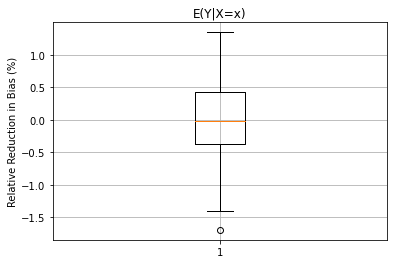

In [9]:
reductions = np.asarray(reductions)
plt.boxplot(reductions)
plt.title('E(Y|X=x)')
plt.ylabel('Relative Reduction in Bias (%)')
plt.grid()
plt.savefig('reduction_in_bias_50runs_N={}.png'.format(N))
plt.show()